## Telco Churn Feature Engineering & ML

### Dataset Story:
Telco churn data includes information about a fictitious telecom company that provided home phone and Internet services to 7,043 California customers in the third quarter. It shows which customers have left, stayed or signed up for their service.

CustomerId: Customer ID  
Gender: Gender  
SeniorCitizen: Whether the client is older (1, 0)  
Partner: Whether the client has a partner (Yes, No)   
Dependents: Whether the client has dependents (Yes, No)  
tenure: The number of months the customer has stayed with the company  
PhoneService: Whether the customer has phone service (Yes, No)  
MultipleLines: Whether the customer has more than one line (Yes, No, No Telephone service)  
InternetService: Customer's internet service provider (DSL, Fiber optic, No)  
OnlineSecurity: Whether the customer has online security (Yes, No, no Internet service)  
OnlineBackup: Whether the customer has an online backup (Yes, No, no Internet service)  
DeviceProtection: Whether the customer has device protection (Yes, No, no Internet service)  
TechSupport: Whether the customer has technical support (Yes, No, no Internet service)  
StreamingTV: Whether the customer has TV streaming (Yes, No, no Internet service)   
StreamingMovies: Whether the customer is streaming movies (Yes, No, no Internet service)  
Contract: Customer's contract duration (Month to month, One year, Two years)  
PaperlessBilling: Whether the customer has a paperless invoice (Yes, No)  
PaymentMethod: Customer's payment method (Electronic check, Postal check, Bank transfer (automatic), Credit card (automatic))  
MonthlyCharges: The amount charged to the customer monthly  
TotalCharges: The total amount charged from the customer  
Churn: Whether the customer uses it (Yes or No)   

## 1. Importing the Libraries and Uploading Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import warnings
warnings.simplefilter(action="ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [3]:
colors = ["#f896d8", "#564592", "#A5E6BA", "#724cf9", "#ca7df9"]

In [4]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2. Exploratory Data Analysis

In [5]:
def check_df(dataframe, head=5):
    print('\033[1m' + '------------------ Shape ------------------' + '\033[0m')
    print(dataframe.shape)

    print('\033[1m' + '------------------ Types ------------------' + '\033[0m')
    print(dataframe.dtypes)

    print('\033[1m' + '------------------ Columns ------------------' + '\033[0m')
    print(dataframe.columns)

    print('\033[1m' + '--------------- Unique Elements ---------------' + '\033[0m')
    print(dataframe.nunique())

    print('\033[1m' + '------------------ NA ------------------' + '\033[0m')
    print(dataframe.isnull().sum())

In [6]:
check_df(df)

------------------ Shape ------------------
(7043, 21)
------------------ Types ------------------
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
------------------ Columns ------------------
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'Pa

In [7]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [8]:
df.dropna(inplace=True)

In [9]:
df['TotalCharges'].isnull().sum()

0

In [10]:
def grab_col_names(df, cat_th=10, car_th=20):
    """
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
            df: Dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                threshold value for numeric but categorical variables
        car_th: int, optinal
                threshold value for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical but cardinal variable list

    Examples
    ------
        You just need to call the function and send the dataframe.)

        --> grab_col_names(df)

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables:
        cat_cols + num_cols + cat_but_car = number of variables

    """

    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print('\033[1m' + '------------------ Shape ------------------' + '\033[0m')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}', "\n")

    return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

------------------ Shape ------------------
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1 



In [12]:
df["Churn"].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [13]:
print('\033[1m' + '------------------ Categorical Cols ------------------' + '\033[0m')
print(cat_cols)

print('\033[1m' + '------------------ Numerical Cols ------------------' + '\033[0m')
print(num_cols)

print('\033[1m' + '------------------ Cardinal Cols ------------------' + '\033[0m')
print(cat_but_car)

------------------ Categorical Cols ------------------
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen']
------------------ Numerical Cols ------------------
['tenure', 'MonthlyCharges', 'TotalCharges']
------------------ Cardinal Cols ------------------
['customerID']


In [14]:
def num_summary(dataframe, col_name, target):
    print(f'\033[1m' + f'------------------ {col_name.upper()} ------------------' + '\033[0m')
    quantiles = [0.01, 0.25, 0.50, 0.75, 0.99]
    print(dataframe.groupby(target)[col_name].describe(percentiles=quantiles))

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    sns.histplot(dataframe[col_name], ax=axes[0, 0], color=colors[1])
    sns.barplot(data=dataframe, x=col_name, y=target, ax=axes[0, 1], palette=colors, estimator=np.mean)
    sns.boxplot(data=df, y=col_name, ax=axes[1, 0], color=colors[2])
    sns.histplot(data=df, x=col_name, hue=target, kde=True, ax=axes[1, 1], palette=[colors[0], colors[2]])

    plt.show()

------------------ TENURE ------------------
        count       mean        std  min   1%   25%   50%   75%   99%   max
Churn                                                                      
No     5163.0  37.650010  24.076940  1.0  1.0  15.0  38.0  61.0  72.0  72.0
Yes    1869.0  17.979133  19.531123  1.0  1.0   2.0  10.0  29.0  70.0  72.0


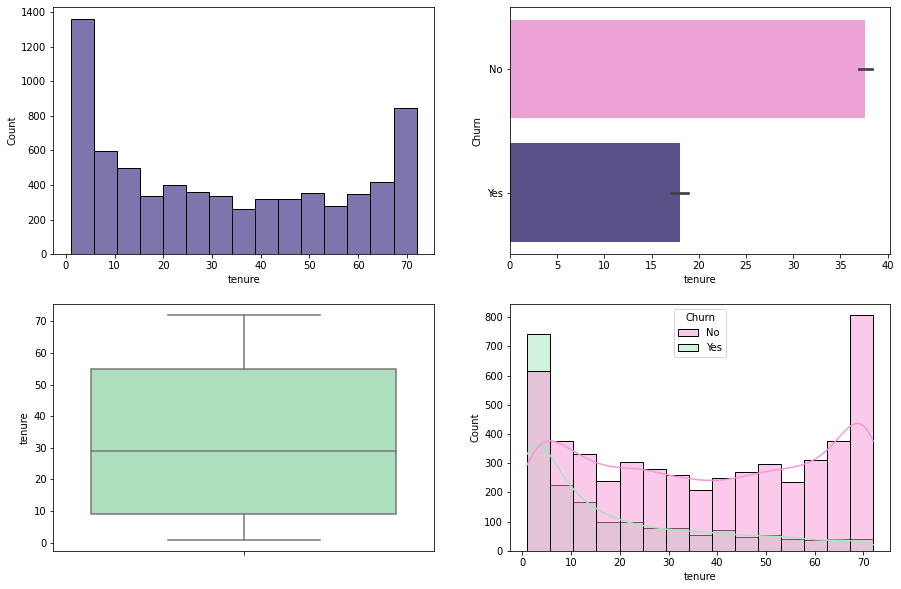

------------------ MONTHLYCHARGES ------------------
        count       mean        std    min      1%    25%    50%     75%      99%     max
Churn                                                                                    
No     5163.0  61.307408  31.094557  18.25  19.150  25.10  64.45  88.475  115.100  118.75
Yes    1869.0  74.441332  24.666053  18.85  19.484  56.15  79.65  94.200  111.132  118.35


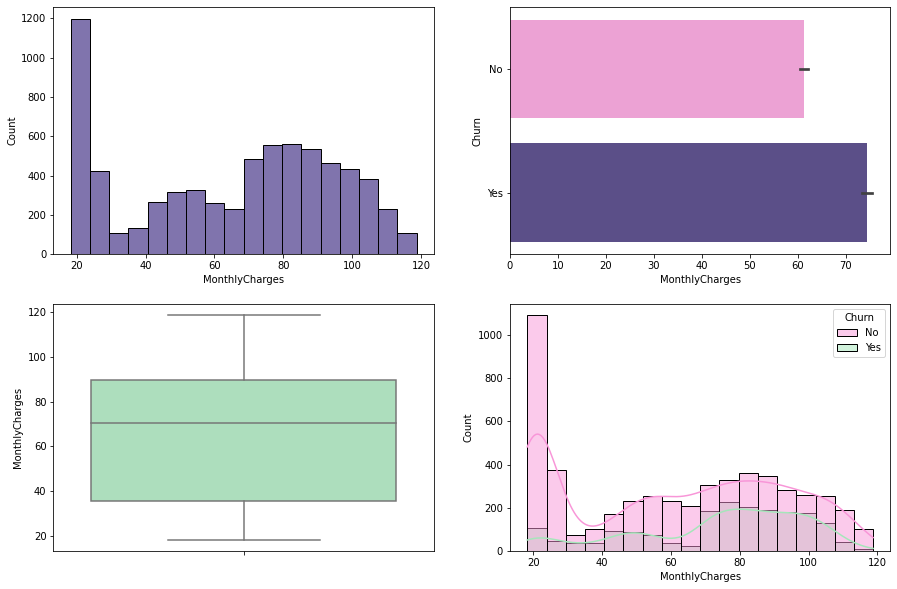

------------------ TOTALCHARGES ------------------
        count         mean          std    min      1%      25%      50%       75%       99%      max
Churn                                                                                                
No     5163.0  2555.344141  2329.456984  18.80  19.900  577.825  1683.60  4264.125  8138.040  8672.45
Yes    1869.0  1531.796094  1890.822994  18.85  19.834  134.500   703.55  2331.300  7436.802  8684.80


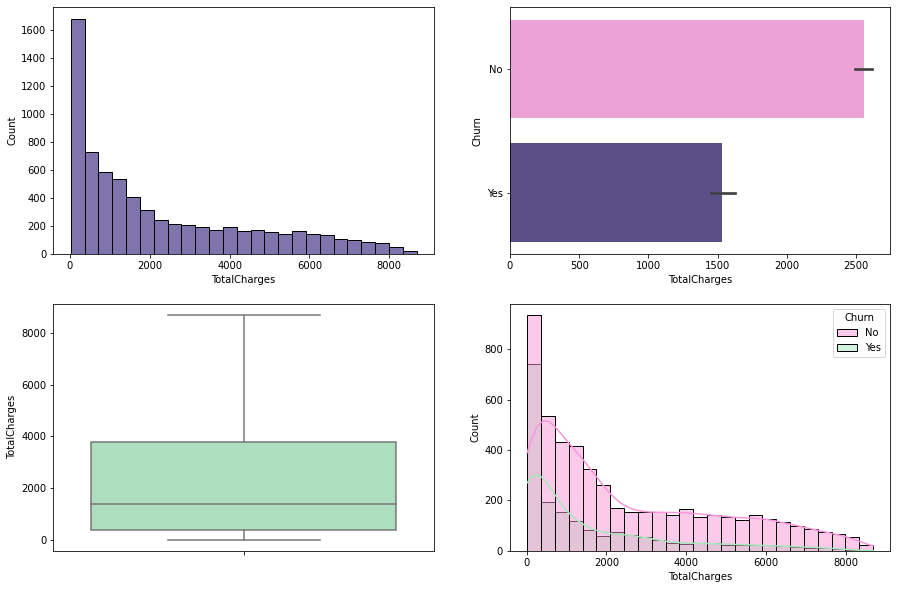

In [15]:
for i, col_name in enumerate(num_cols):
    num_summary(df, col_name, "Churn")

In [16]:
def cat_summary(dataframe, col_name, target):
    print(f'\033[1m' + f'------------------ {col_name.upper()} ------------------' + '\033[0m')

    print(dataframe[col_name].value_counts())

    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.pie(dataframe[col_name].value_counts().values.tolist(),
            labels=dataframe[col_name].value_counts().keys().tolist(),
            colors=colors,
            autopct='%1.0f%%')
    circle = plt.Circle((0, 0), 0.7, color='white')
    p = plt.gcf()
    p.gca().add_artist(circle)

    plt.subplot(1, 3, 2)
    sns.countplot(data=dataframe, x=col_name, palette=colors)
    plt.tight_layout(pad=3)

    plt.subplot(1, 3, 3)
    sns.countplot(data=dataframe, x=col_name, hue=target, palette=colors)

    plt.show()

------------------ GENDER ------------------
Male      3549
Female    3483
Name: gender, dtype: int64


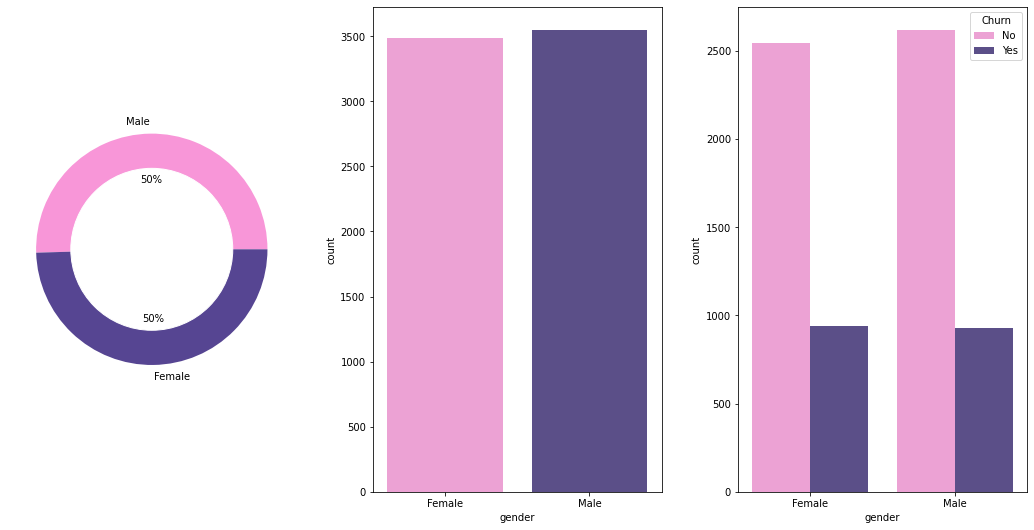

------------------ PARTNER ------------------
No     3639
Yes    3393
Name: Partner, dtype: int64


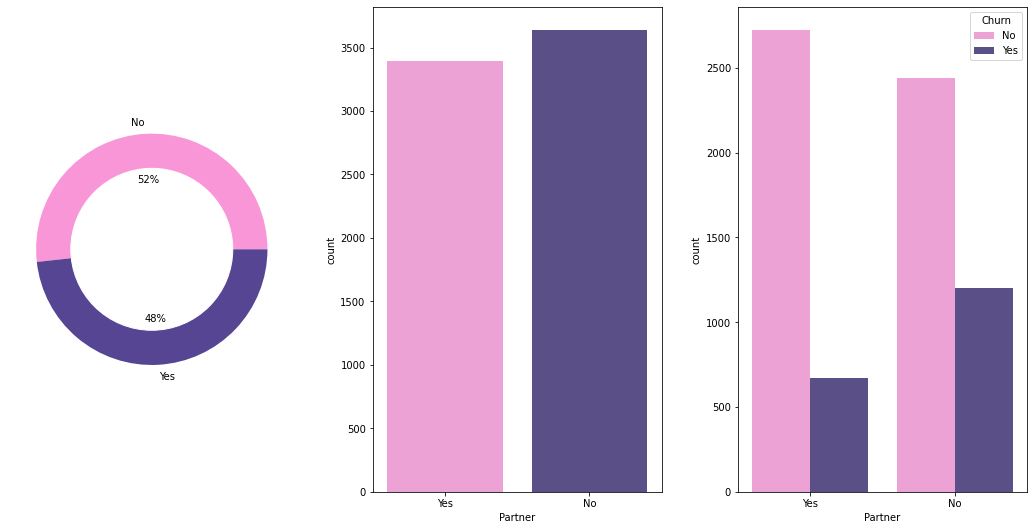

------------------ DEPENDENTS ------------------
No     4933
Yes    2099
Name: Dependents, dtype: int64


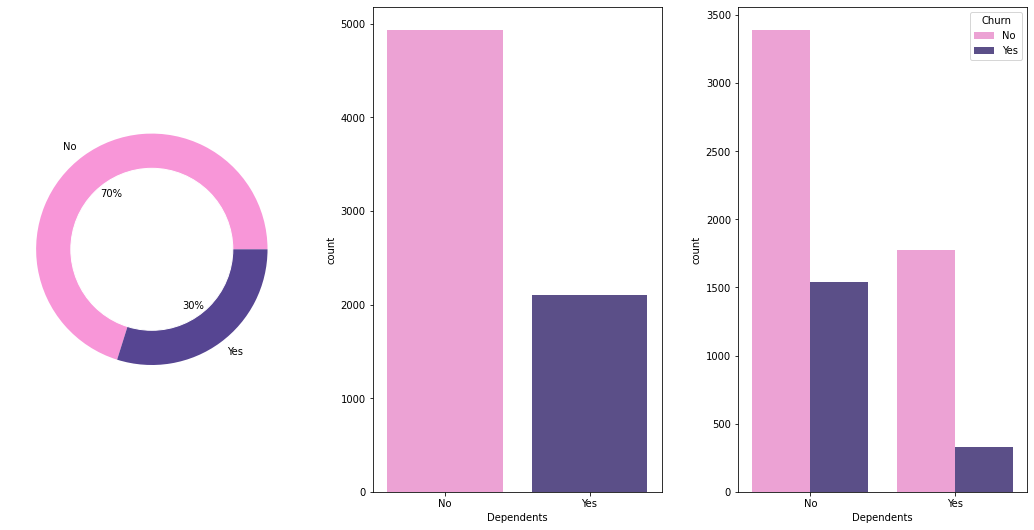

------------------ PHONESERVICE ------------------
Yes    6352
No      680
Name: PhoneService, dtype: int64


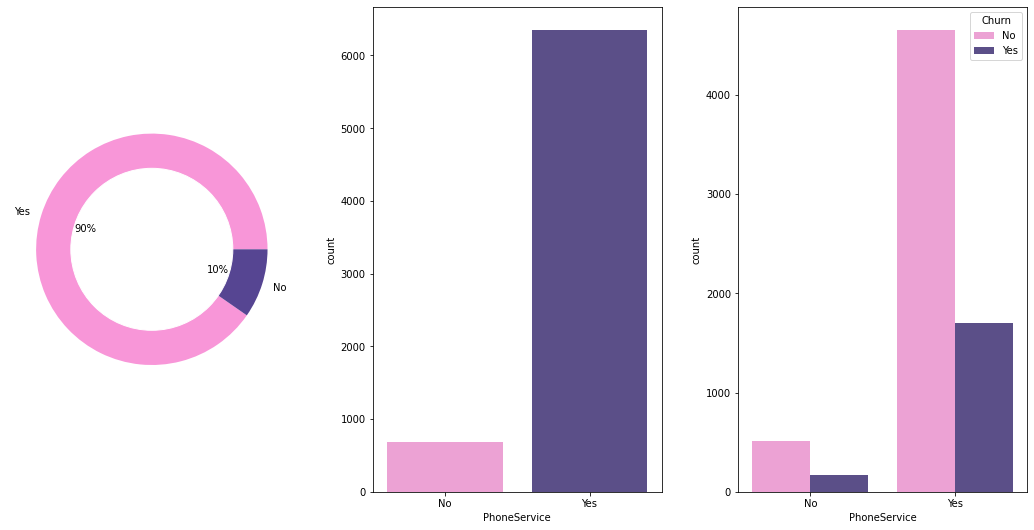

------------------ MULTIPLELINES ------------------
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64


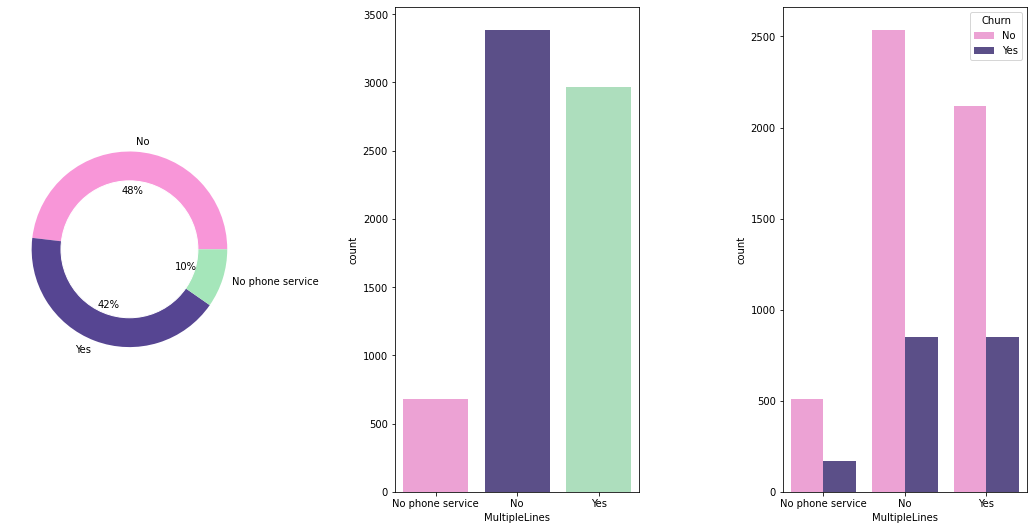

------------------ INTERNETSERVICE ------------------
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64


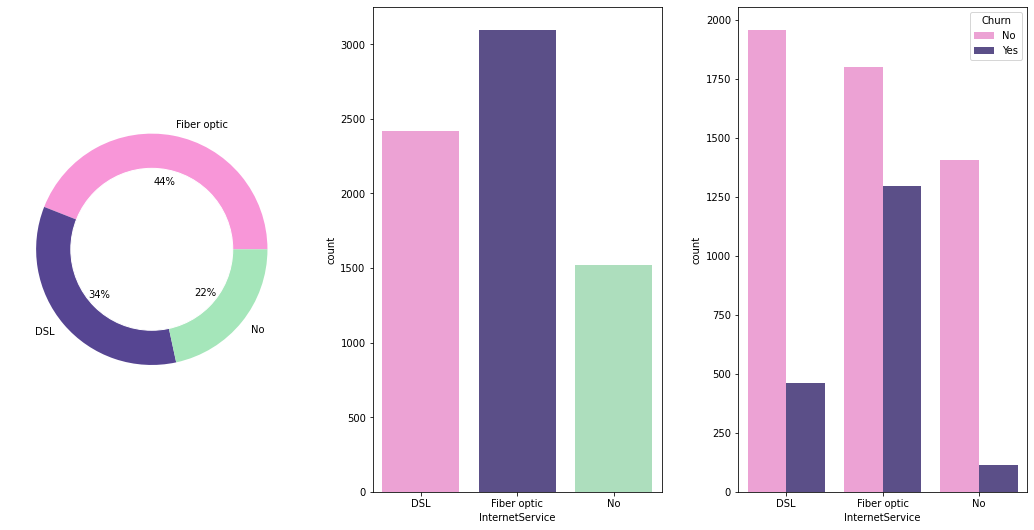

------------------ ONLINESECURITY ------------------
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64


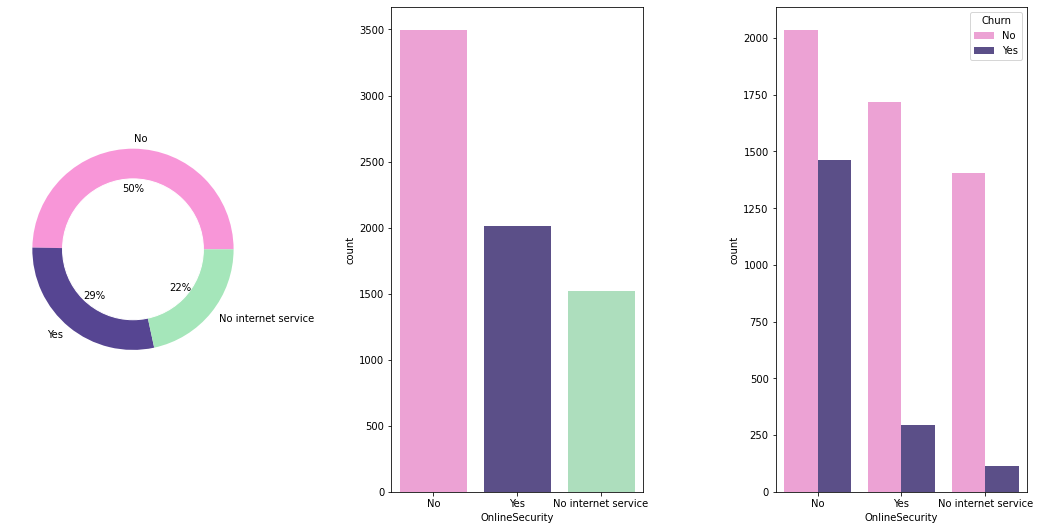

------------------ ONLINEBACKUP ------------------
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64


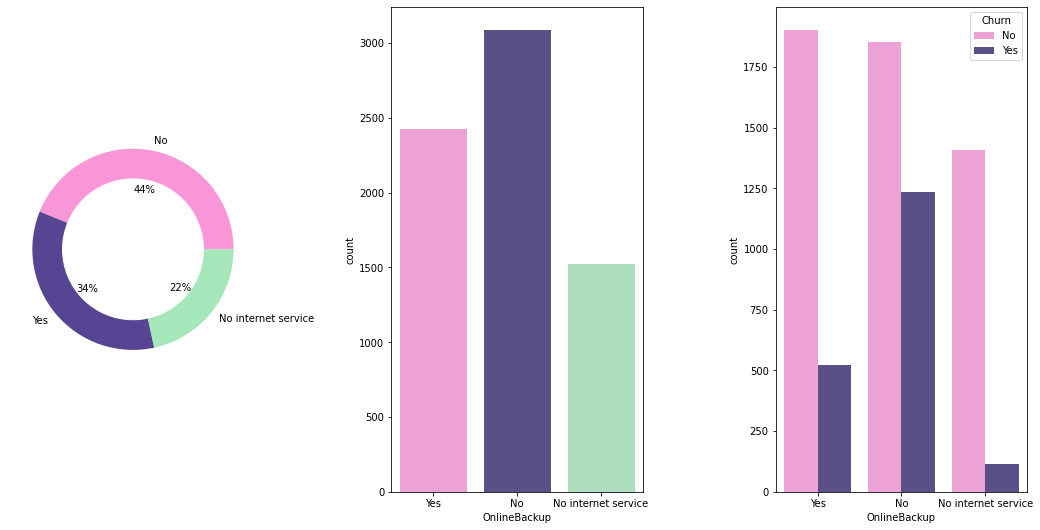

------------------ DEVICEPROTECTION ------------------
No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64


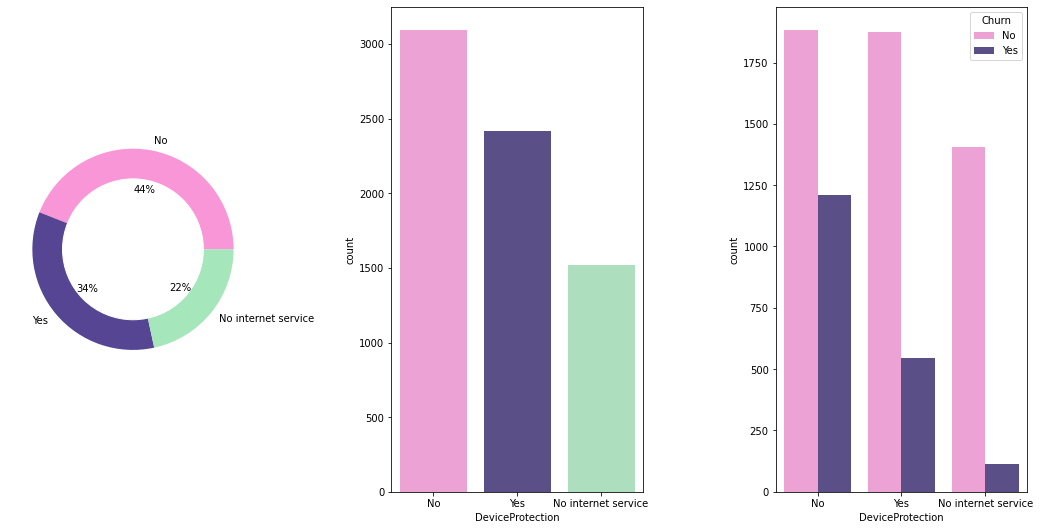

------------------ TECHSUPPORT ------------------
No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64


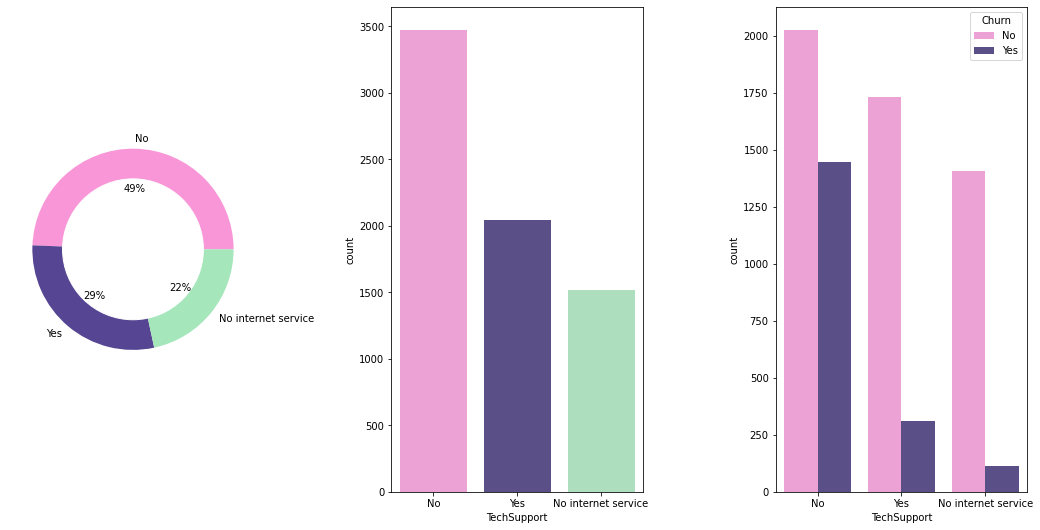

------------------ STREAMINGTV ------------------
No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64


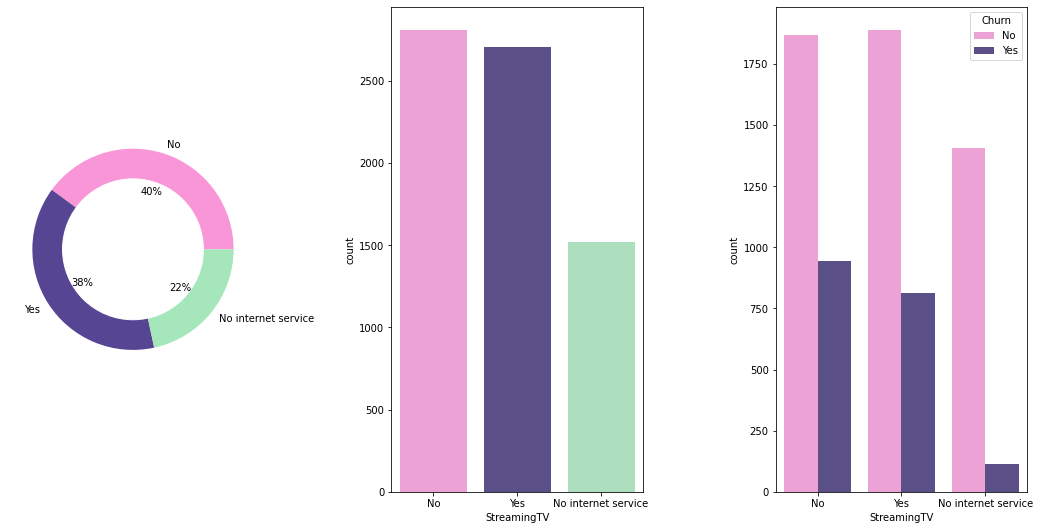

------------------ STREAMINGMOVIES ------------------
No                     2781
Yes                    2731
No internet service    1520
Name: StreamingMovies, dtype: int64


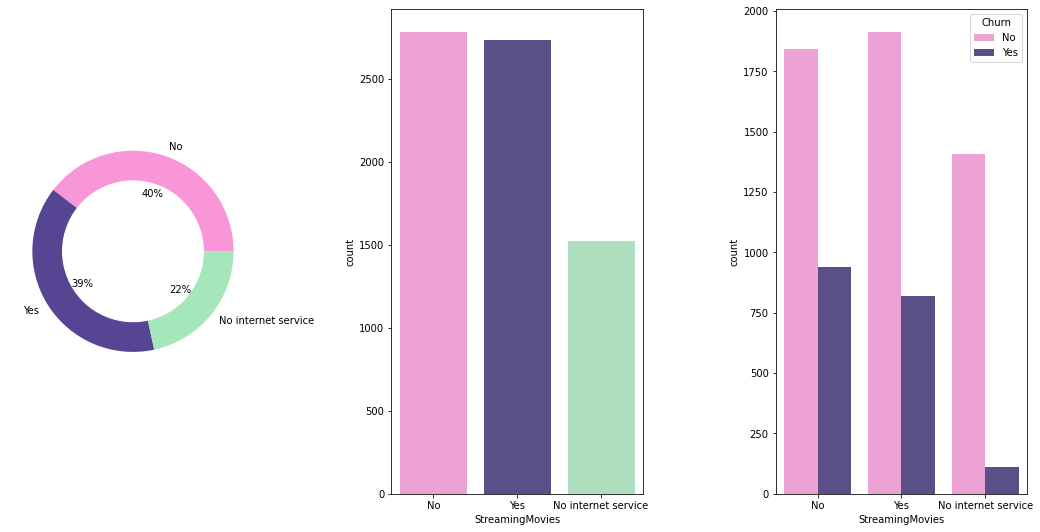

------------------ CONTRACT ------------------
Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64


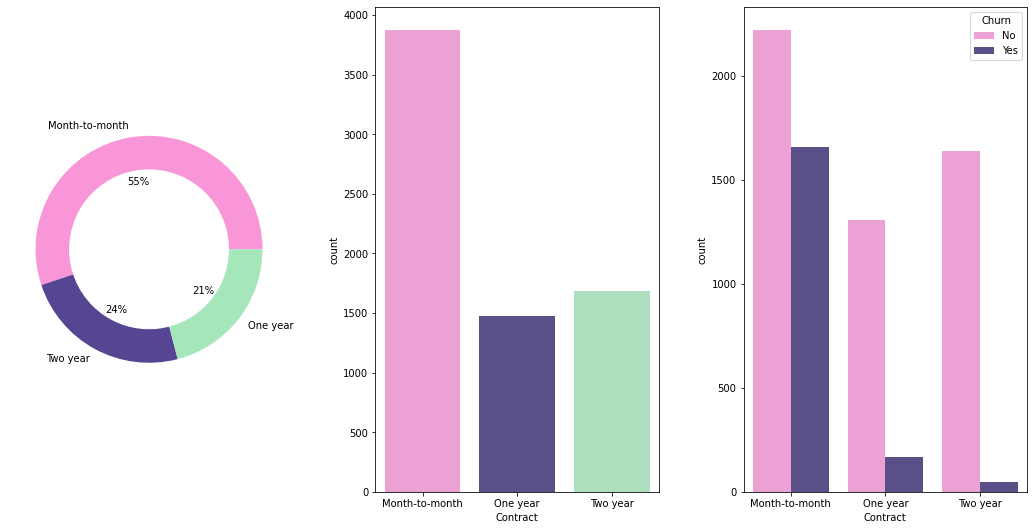

------------------ PAPERLESSBILLING ------------------
Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64


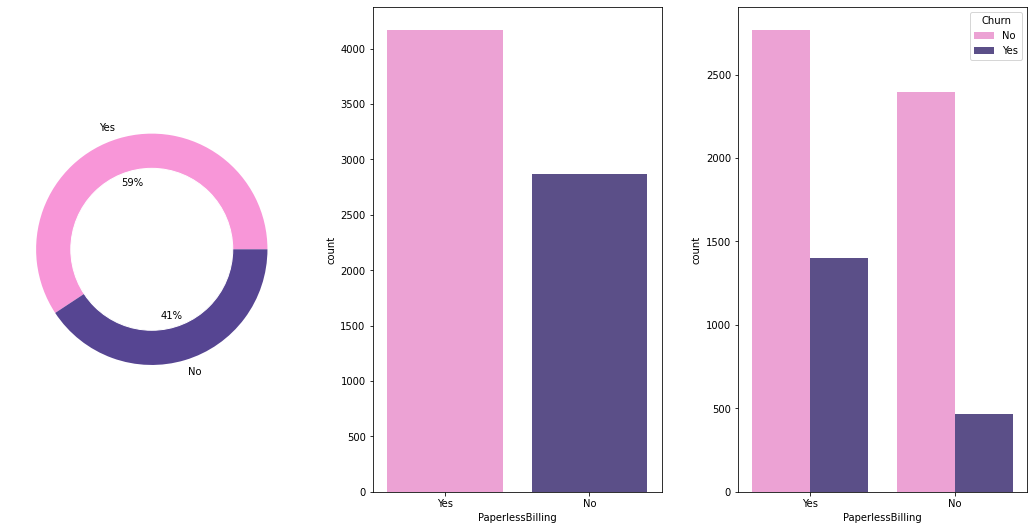

------------------ PAYMENTMETHOD ------------------
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64


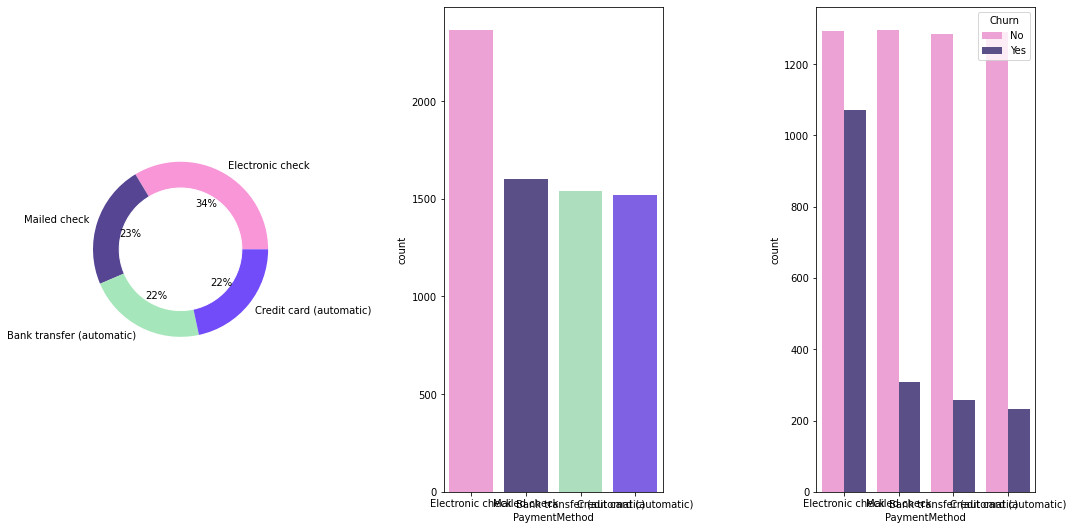

------------------ CHURN ------------------
No     5163
Yes    1869
Name: Churn, dtype: int64


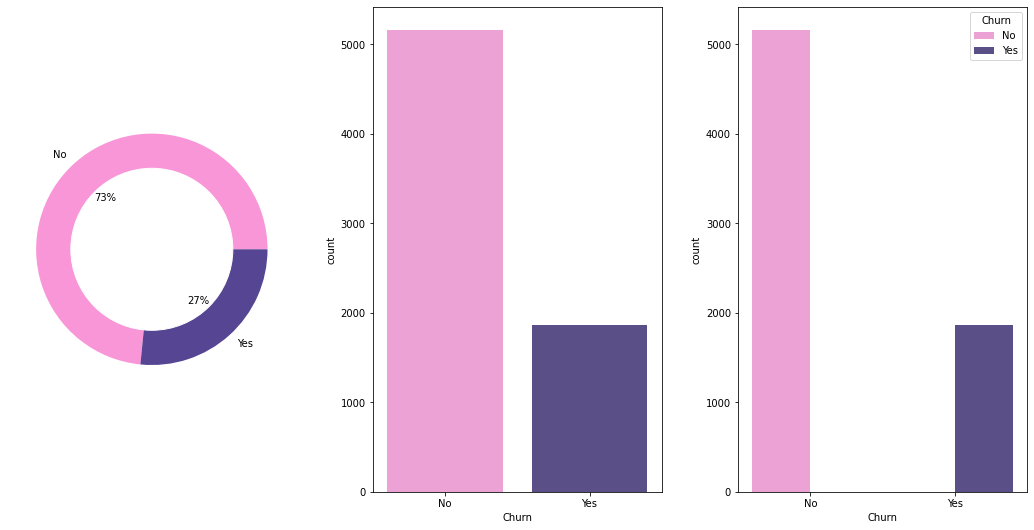

------------------ SENIORCITIZEN ------------------
0    5890
1    1142
Name: SeniorCitizen, dtype: int64


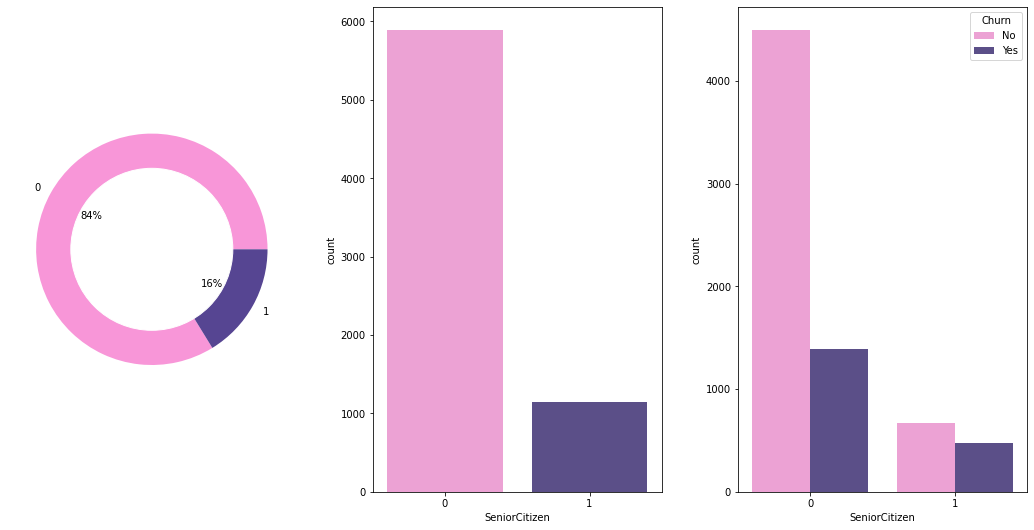

In [17]:
for col in cat_cols:
    cat_summary(df, col, "Churn")

## 3. Outlier Analysis

In [18]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [19]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [20]:
for i in num_cols:
    print(i, check_outlier(df, i))

tenure False
MonthlyCharges False
TotalCharges False


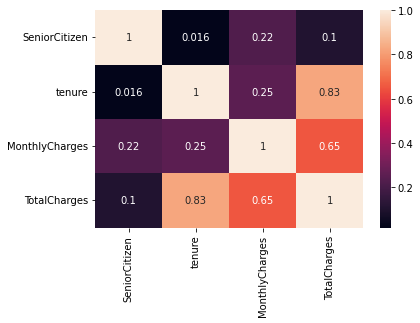

In [21]:
sns.heatmap(df.corr(), annot=True);

## 4. Feature Engineering

In [22]:
lbe = LabelEncoder()

In [23]:
df['Churn'] = lbe.fit_transform(df['Churn'])
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [24]:
df.nunique()

customerID          7032
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

In [25]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
Churn,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00


In [26]:
df['Categorical_tenure'] = pd.qcut(df['tenure'], 4, labels=['tenure_Q1', 'tenure_Q2', 'tenure_Q3', 'tenure_Q4'])

In [27]:
print(df.groupby('Categorical_tenure').agg({'Churn': 'mean'}))

                       Churn
Categorical_tenure          
tenure_Q1           0.500814
tenure_Q2           0.283382
tenure_Q3           0.188482
tenure_Q4           0.077493


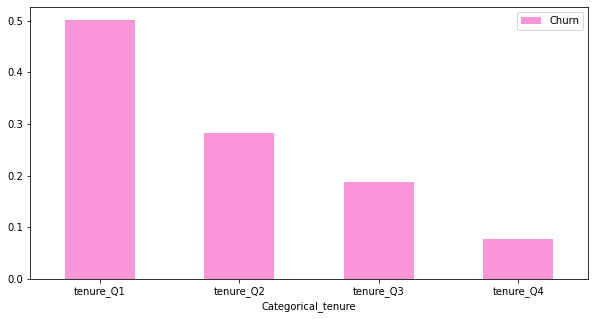

In [28]:
df.groupby('Categorical_tenure').agg({'Churn': 'mean'}).plot(kind='bar', rot=0, figsize=(10, 5), color=colors);

In [29]:
df['Categorical_MonthlyCharges'] = pd.qcut(df['MonthlyCharges'], 4, labels=
['MonthlyCharges_Q1', 'MonthlyCharges_Q2'
    , 'MonthlyCharges_Q3', 'MonthlyCharges_Q4'])

In [30]:
print(df.groupby('Categorical_MonthlyCharges').agg({'Churn': 'mean'}))

                               Churn
Categorical_MonthlyCharges          
MonthlyCharges_Q1           0.113197
MonthlyCharges_Q2           0.245883
MonthlyCharges_Q3           0.375499
MonthlyCharges_Q4           0.328783


<AxesSubplot:xlabel='Categorical_MonthlyCharges'>

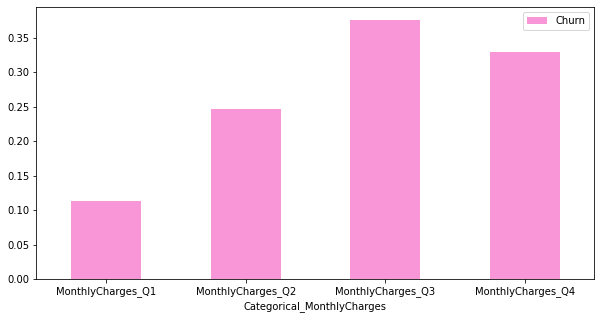

In [31]:
df.groupby('Categorical_MonthlyCharges').agg({'Churn': 'mean'}).plot(kind='bar', rot=0, figsize=(10, 5), color=colors)

In [32]:
df['Categorical_TotalCharges'] = pd.qcut(df['TotalCharges'], 4, labels=
['TotalCharges_Q1', 'TotalCharges_Q2'
    , 'TotalCharges_Q3', 'TotalCharges_Q4'])

In [33]:
print(df.groupby('Categorical_TotalCharges').agg({'Churn': 'mean'}))

                             Churn
Categorical_TotalCharges          
TotalCharges_Q1           0.434585
TotalCharges_Q2           0.253129
TotalCharges_Q3           0.230375
TotalCharges_Q4           0.145051


<AxesSubplot:xlabel='Categorical_TotalCharges'>

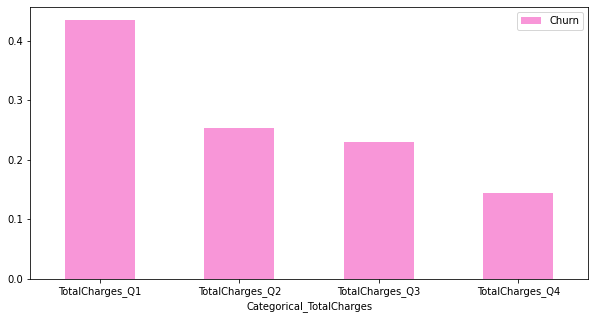

In [34]:
df.groupby('Categorical_TotalCharges').agg({'Churn': 'mean'}).plot(kind='bar', rot=0, figsize=(10, 5), color=colors)

In [35]:
df.groupby('Categorical_TotalCharges').agg({'MonthlyCharges': 'mean'})

,MonthlyCharges
Categorical_TotalCharges,
TotalCharges_Q1,46.496359
TotalCharges_Q2,50.266468
TotalCharges_Q3,68.867548
TotalCharges_Q4,93.562457


In [36]:
df.groupby('Categorical_TotalCharges').agg({'tenure': 'mean'})

,tenure
Categorical_TotalCharges,
TotalCharges_Q1,4.375427
TotalCharges_Q2,24.644482
TotalCharges_Q3,39.372582
TotalCharges_Q4,61.294653


In [37]:
df["NEW_customerID"] = df["customerID"].apply(lambda x: [x for x in x.split("-")][0])

In [38]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Categorical_tenure,Categorical_MonthlyCharges,Categorical_TotalCharges,NEW_customerID
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,tenure_Q1,MonthlyCharges_Q1,TotalCharges_Q1,7590
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,tenure_Q3,MonthlyCharges_Q2,TotalCharges_Q3,5575
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,tenure_Q1,MonthlyCharges_Q2,TotalCharges_Q1,3668
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,tenure_Q3,MonthlyCharges_Q2,TotalCharges_Q3,7795
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,tenure_Q1,MonthlyCharges_Q3,TotalCharges_Q1,9237


In [39]:
def target_density(dataframe, target, numerical_col):
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df[col][df.Churn == 1], color=colors[0])
    sns.kdeplot(df[col][df.Churn == 0], color=colors[3])
    plt.legend(['Churn', 'No Churn'])
    plt.title("Churn Density of Numerical Variables")
    plt.show()

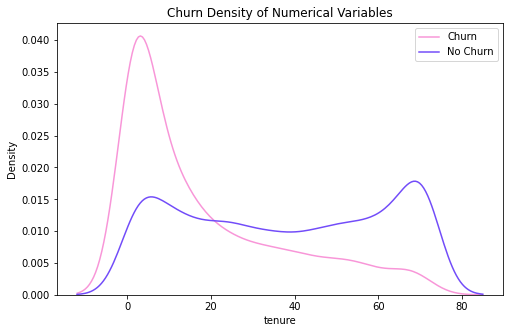

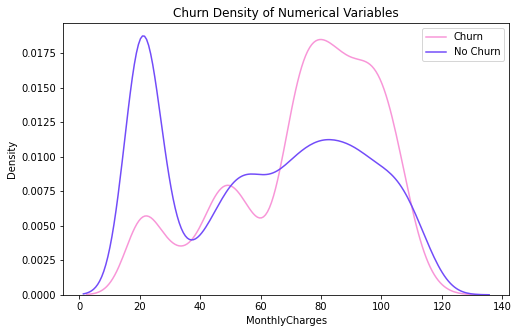

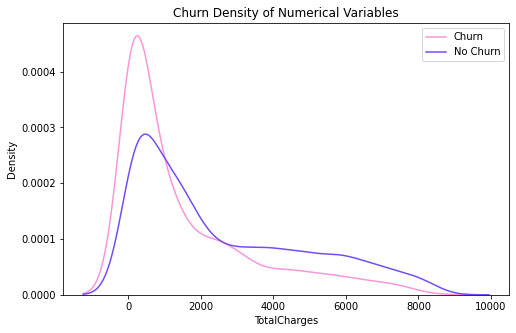

In [40]:
for col in num_cols:
    target_density(df, "Churn", col)

In [41]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [42]:
ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'Categorical_tenure',
 'Categorical_MonthlyCharges',
 'Categorical_TotalCharges']

In [43]:
df = one_hot_encoder(df, ohe_cols)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_customerID,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Categorical_tenure_tenure_Q2,Categorical_tenure_tenure_Q3,Categorical_tenure_tenure_Q4,Categorical_MonthlyCharges_MonthlyCharges_Q2,Categorical_MonthlyCharges_MonthlyCharges_Q3,Categorical_MonthlyCharges_MonthlyCharges_Q4,Categorical_TotalCharges_TotalCharges_Q2,Categorical_TotalCharges_TotalCharges_Q3,Categorical_TotalCharges_TotalCharges_Q4
0,7590-VHVEG,Female,0,Yes,No,1,No,Yes,29.85,29.85,0,7590,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,56.95,1889.50,0,5575,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
2,3668-QPYBK,Male,0,No,No,2,Yes,Yes,53.85,108.15,1,3668,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,7795-CFOCW,Male,0,No,No,45,No,No,42.30,1840.75,0,7795,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
4,9237-HQITU,Female,0,No,No,2,Yes,Yes,70.70,151.65,1,9237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [44]:
df['gender'] = lbe.fit_transform(df['gender'])
df['Partner'] = lbe.fit_transform(df['Partner'])
df['Dependents'] = lbe.fit_transform(df['Dependents'])
df['PhoneService'] = lbe.fit_transform(df['Partner'])
df['PaperlessBilling'] = lbe.fit_transform(df['PaperlessBilling'])

In [45]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_customerID,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Categorical_tenure_tenure_Q2,Categorical_tenure_tenure_Q3,Categorical_tenure_tenure_Q4,Categorical_MonthlyCharges_MonthlyCharges_Q2,Categorical_MonthlyCharges_MonthlyCharges_Q3,Categorical_MonthlyCharges_MonthlyCharges_Q4,Categorical_TotalCharges_TotalCharges_Q2,Categorical_TotalCharges_TotalCharges_Q3,Categorical_TotalCharges_TotalCharges_Q4
0,7590-VHVEG,0,0,1,0,1,1,1,29.85,29.85,0,7590,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,34,0,0,56.95,1889.50,0,5575,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
2,3668-QPYBK,1,0,0,0,2,0,1,53.85,108.15,1,3668,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,42.30,1840.75,0,7795,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
4,9237-HQITU,0,0,0,0,2,0,1,70.70,151.65,1,9237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [46]:
scaler = StandardScaler()

In [47]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

------------------ Shape ------------------
cat_cols: 37
num_cols: 3
cat_but_car: 2
num_but_cat: 37 



In [48]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [49]:
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_customerID,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Categorical_tenure_tenure_Q2,Categorical_tenure_tenure_Q3,Categorical_tenure_tenure_Q4,Categorical_MonthlyCharges_MonthlyCharges_Q2,Categorical_MonthlyCharges_MonthlyCharges_Q3,Categorical_MonthlyCharges_MonthlyCharges_Q4,Categorical_TotalCharges_TotalCharges_Q2,Categorical_TotalCharges_TotalCharges_Q3,Categorical_TotalCharges_TotalCharges_Q4
0,7590-VHVEG,0,0,1,0,-1.280248,1,1,-1.161694,-0.994194,0,7590,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,0.064303,0,0,-0.260878,-0.173740,0,5575,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
2,3668-QPYBK,1,0,0,0,-1.239504,0,1,-0.363923,-0.959649,1,3668,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,7795-CFOCW,1,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,7795,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
4,9237-HQITU,0,0,0,0,-1.239504,0,1,0.196178,-0.940457,1,9237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


## 5. Modelling

In [50]:
df = df.drop('customerID', axis=1)

In [51]:
df['NEW_customerID'] = pd.to_numeric(df['NEW_customerID'], errors='coerce')

In [52]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_customerID,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Categorical_tenure_tenure_Q2,Categorical_tenure_tenure_Q3,Categorical_tenure_tenure_Q4,Categorical_MonthlyCharges_MonthlyCharges_Q2,Categorical_MonthlyCharges_MonthlyCharges_Q3,Categorical_MonthlyCharges_MonthlyCharges_Q4,Categorical_TotalCharges_TotalCharges_Q2,Categorical_TotalCharges_TotalCharges_Q3,Categorical_TotalCharges_TotalCharges_Q4
0,0,0,1,0,-1.280248,1,1,-1.161694,-0.994194,0,7590,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0.064303,0,0,-0.260878,-0.173740,0,5575,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0
2,1,0,0,0,-1.239504,0,1,-0.363923,-0.959649,1,3668,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,7795,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0
4,0,0,0,0,-1.239504,0,1,0.196178,-0.940457,1,9237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   gender                                        7032 non-null   int64  
 1   SeniorCitizen                                 7032 non-null   int64  
 2   Partner                                       7032 non-null   int64  
 3   Dependents                                    7032 non-null   int64  
 4   tenure                                        7032 non-null   float64
 5   PhoneService                                  7032 non-null   int64  
 6   PaperlessBilling                              7032 non-null   int64  
 7   MonthlyCharges                                7032 non-null   float64
 8   TotalCharges                                  7032 non-null   float64
 9   Churn                                         7032 non-null   i

In [54]:
y = df['Churn']
X = df.drop('Churn', axis=1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [56]:
catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [57]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred, y_test), 2)}")
print(f"Precision: {round(precision_score(y_pred, y_test), 2)}")
print(f"F1: {round(f1_score(y_pred, y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred, y_test), 2)}")

Accuracy: 0.8
Recall: 0.65
Precision: 0.51
F1: 0.57
Auc: 0.74


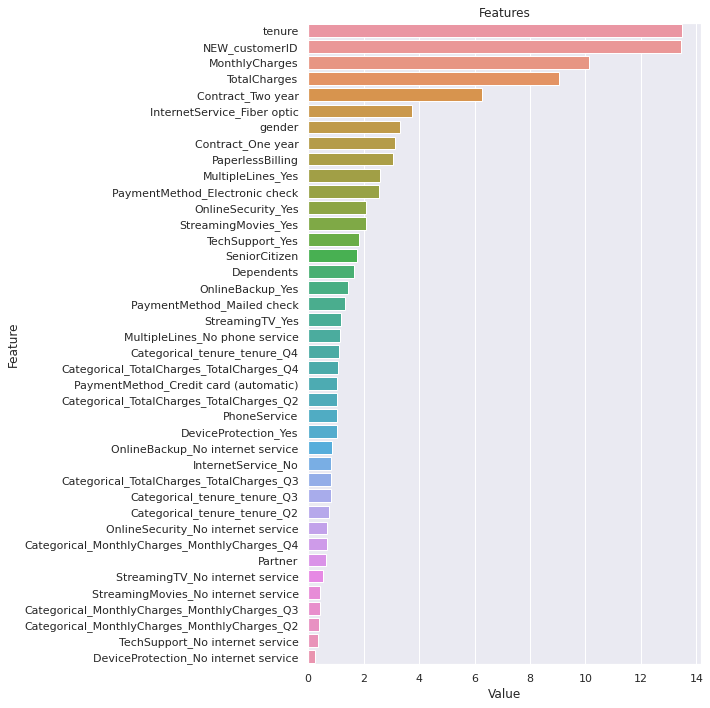

In [58]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(catboost_model, X_train)